# Influence of precipitation and storage through the critical zone and across spatial scales
Eve Tipps
12/17/25

# Introduction

Freshwater is a limited resource that provides vital drinking water to communities worldwide. Due to climate change-driven shifts in precipitation and temperature, freshwater resources are becoming increasingly scarce. Improving and preserving the quality of accessible water is of the utmost importance. Headwater streams act as key indicators of freshwater quality and ecosystem functioning. As solutes are exported downstream, rivers integrate signals of ecosystem vulnerability from upstream transport and the surrounding landscape (Stewart et al., 2022). Understanding headwater stream variability is an important step toward understanding variability in freshwater resources.

Variability in headwater streams is driven by processes in the critical zone. The critical zone is “Earth’s outer skin” and comprises the layers of Earth from the bedrock to the atmosphere. In this zone, geology, soil, water, biological organisms, and the atmosphere interact to form Earth’s living ecosystems. Deeper layers of the critical zone source more geogenic solutes, indicative of weathering, whereas more shallow layers of the critical zone source more biogenic solutes, which are the result of nutrient cycling and biogeochemical reactions. These stratifications in the biogeochemistry of the critical zone and their interactions with flowing water imprint on the chemistry of freshwater exports (Stewart et al., 2022).


![Title](critzone.jpg)
Figure 1: Conceptual diagram of how deep or shallow flowpaths move through the critical zone to influence surface water chemistry (Stewart et al., 2022).

Hydrometeorological conditions, like precipitation, can further influence solute export from the critical zone. Solute export may be expected to increase during periods of high precipitation and decrease following extensive droughts. However, the source of solutes within the critical zone complicates these patterns. During wet periods, solutes from deeper layers in the critical zone may be more diluted, with their concentrations decreasing as discharge increases. In contrast, more shallowly sourced solutes display a flushing behavior, increasing with higher discharge (Stewart et al., 2022). Further, much of the research on hydrology and watershed export has mainly focused on small, undisturbed watersheds, especially in temperate ecosystems. Understanding the impact of hydrometeorological forcings on the critical zone across spatial scales is crucial, as it is unclear whether processes observed in small watersheds can be directly applied to larger watersheds.

This report serves as a qualitative first look at the relationship between CQ dynamics, storage, and the legacy of hydrometeorological conditions like precipitation. This report will analyze a series of solutes that are sourced from different depths of the critical zone and plot their CQ behavior to understand how discharge and precipitation influence the sourcing of solutes, as done by Stewart (2022). 


# Research question and hypotheses
How does precipitation and storage impact the variability of surface water chemistry?
How will this relationship change with watershed size?

H1: More comprehensive storage (more antecedent P/R) would explain more variability in solute fluxes, but specifically in more shallow sourced solutes that need higher flow paths to be mobilized.

H2: More wet years will result in more enriching behavior from shallow sourced solutes because more precipitation will result in high flow paths that are in contact with shallow, biogenic solutes, whereas the behavior of deep-sourced solutes will not be strongly impacted by annual precipitation.


# Site description and data sets

This report utilizes data for the Lamprey River watershed from the Lamprey River Hydrological Observatory (LRHO) in southeastern New Hampshire (USA). In total, the LRHO comprises a basin area of 554 km2 that drains into the Great Bay Estuary. The watershed is 73% forested but is characterized as a mixed land-use and suburban environment. The mean annual temperature is 9.2 ± 0.8°C, and the mean annual precipitation is 127 ± 6 cm with 2-16% as snow. This report will focus on two sites along the mainstem of the LRHO, LMP 27 and LMP 72. Water chemistry for LMP 27 is collected on a monthly basis and water chemistry for LMP 72 is collected on a weekly basis. LMP 27 drains 144.3 km2 whereas LMP 72 drains 426.9 km2. These sites are each associated with a USGS gauge and are arranged in a nested sampling design to understand how hydrologic processes may scale across watershed size (Wymore et al., 2021). 

Water chemistry from each site was collected and analyzed by the New Hampshire Water Quality Analysis Lab. This report will focus on water chemistry data collected since 2013, and will focus on calcium, silicon dioxide, non-particulate or dissolved organic carbon (DOC), nitrate, and specific conductance. Calcium and silicon dioxide are more geogenic solutes that are typically sourced from deeper layers of the critical zone, whereas DOC and nitrate are more reactive, biogenic solutes that are typically sourced from more shallow layers of the critical zone. Specific conductance is a measurement of the collective concentration of dissolved solutes, and may represent an integrated signal from solutes throughout the critical zone.

Daily discharge data since 2013 for LMP 27 was collected from USGS gauge 01073319. Daily discharge data since 2013 for LMP 72 was collected from USGS gauge 01073500. Daily precipitation data since 2013 for the LRHO was collected from the Thompson Farm NOAA Station at NH Durham 2 SSW.


![Title](LRHOmap.jpg)
Figure 1: Site map of LRHO. Sites LMP 27 and LMP 72 are marked with red stars.

In [1]:
# Imports
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
import openpyxl

In [2]:
# Parameters
infile27 = 'usgs_raymond_2013.txt'
infile72 = 'usgs_newmarket_2013.txt'

drainage_area27 = 144.3
drainage_area72 = 476.9

infile_p = 'thompsonppt.csv'

grab_input = '20251001 Lamprey Weekly Monthly QAQC w formatting.xlsx'

info = 'sites.txt'

chems = 'analytes.txt'


# Functions

In [3]:
# Function to read in data sets
CFS_TO_MM_DAY = (1/5280)**2 * 304.8 * 86400
IN_TO_MM = 25.4

def read_data(datafile, file_type, drainage_area=None, sites=None, analytes=None):
    """
    Unified data-reading function for:
        - 'usgs' discharge files (.txt or .csv)
        - 'ppt' precipitation files (.csv)
        - 'grab' grab-sample Excel files (.xlsx)

    Parameters
    ----------
    datafile : str
        Path to the input data file.

    file_type : str
        One of: 'usgs', 'ppt', 'grab'.

    drainage_area : float, optional
        Required if file_type='usgs'. Drainage area in square miles.

    sites : list, optional
        Required if file_type='grab'. List of sample site names.
        
    analytes : list, optional
        Required if file_type='grab'. Columns (chemical analytes) to keep.

    Returns
    -------
    DataFrame
        The cleaned and processed dataset.
    """

    file_type = file_type.lower()

    # ------------------------------------------------------------------
    # USGS DISCHARGE
    # ------------------------------------------------------------------
    if file_type == "usgs":
        if drainage_area is None:
            raise ValueError("For file_type='usgs', you must supply drainage_area.")

        data = pd.read_csv(datafile, delimiter='\t', comment='#',
                           index_col=['datetime'])

        # keep only 00060 columns without the qualifier
        to_keep = [c for c in data.columns if ("00060" in c and "cd" not in c)]
        data = data[to_keep]

        data = data.iloc[1:, :]  # drop metadata row
        data.index = pd.to_datetime(data.index)

        data.rename(columns={data.columns[0]: 'Q_CFS'}, inplace=True)
        data['Q_CFS'] = pd.to_numeric(data['Q_CFS'], errors='coerce')

        # clean NaNs
        data.replace([9999, 'NaN', -9999, 'Ice', 'Bkw', 'Mnt'],
                     np.nan, inplace=True)

        # convert CFS → mm/day
        data['runoff_MM'] = data['Q_CFS'] / drainage_area * CFS_TO_MM_DAY

        return data

    # ------------------------------------------------------------------
    # PRECIPITATION
    # ------------------------------------------------------------------
    elif file_type == "ppt":
        data = pd.read_csv(datafile,
                           parse_dates=['DATE'], index_col=['DATE'])

        data.replace([9999, 'NaN', -9999], 0, inplace=True)

        # Combine PRCP + MDPR if present
        if 'MDPR' in data.columns:
            data['PRCP'] = np.nansum(data[['PRCP', 'MDPR']].values, axis=1)
            data.drop(columns='MDPR', inplace=True)

        # Convert inches → mm
        data['PRCP_MM'] = data['PRCP'] * IN_TO_MM

        # drop unneeded columns
        drop_cols = {"STATION","NAME","SNOW","SNWD",
                     "DAPR","MDSF","DASF","PRCP"}
        data.drop(columns=drop_cols, errors='ignore', inplace=True)

        return data
   # ------------------------------------------------------------------
    # GRAB SAMPLE EXCEL
    # ------------------------------------------------------------------
    if file_type == "grab":
        if sites is None:
            raise ValueError("For file_type='grab', you must supply sites=list_of_sites.")
        if analytes is None:
            raise ValueError("For file_type='grab', you must supply analytes=list_of_columns_to_keep.")

        data = pd.read_excel(
            datafile,
            parse_dates=['Collection Date'],
            index_col='Collection Date'
        )

        # Keep only rows for the requested sites
        data = data[data['Sample Name'].isin(sites)]

        # Build list of columns to retain:
        # mandatory metadata + analyte columns
        cols_to_keep = ['Sample Name'] + analytes
        existing = [c for c in cols_to_keep if c in data.columns]

        data = data[existing]

        data.sort_index(inplace=True)

        return data

    # ------------------------------------------------------------------
    # INVALID FILE TYPE
    # ------------------------------------------------------------------
    else:
        raise ValueError("file_type must be one of: 'usgs', 'ppt', 'grab'.")

In [4]:
# Function to merge data sets
def merge_data(grab_data=None, discharge_data=None, ppt_data=None, site_name=None):
    """
    Merge dataframes for analysis with options for:
      - grab sample + discharge + optional precipitation
      - discharge + optional precipitation only

    Parameters
    ----------
    grab_data : DataFrame, optional
        Grab sample dataframe, must have column 'Sample Name'.
    discharge_data : DataFrame, optional
        Discharge dataframe, indexed by datetime.
    ppt_data : DataFrame, optional
        Precipitation dataframe, indexed by datetime.
    site_name : str, optional
        Name of the site to filter grab data (only used if grab_data provided).

    Returns
    -------
    merged : DataFrame
        Merged dataframe indexed by datetime with optional 'DOY' column.
    """

    if grab_data is not None:
        if site_name is not None:
            grab_filtered = grab_data.loc[grab_data['Sample Name'] == site_name]
        else:
            grab_filtered = grab_data.copy()

        merged = pd.merge(grab_filtered, discharge_data,
                          left_index=True, right_index=True, how='left')

        if ppt_data is not None:
            merged = pd.merge(merged, ppt_data,
                              left_index=True, right_index=True, how='left')

    elif discharge_data is not None:
        merged = discharge_data.copy()
        if ppt_data is not None:
            merged = pd.merge(merged, ppt_data,
                              left_index=True, right_index=True, how='left')
    else:
        raise ValueError("At least grab_data or discharge_data must be provided.")

    # Drop rows where discharge is missing
    if 'Q_CFS' in merged.columns:
        merged.dropna(subset=['Q_CFS'], inplace=True)

    # Add Day of Year column
    merged['DOY'] = merged.index.dayofyear
    
    # Add Year column
    merged['Year'] = merged.index.year

    return merged


In [5]:
# Function to calculate the flux of each solute
def flux(df, col):
    '''
    Create a new column of solute flux based off of input concentration column and discharge
    
    Parameters
    ----------
    df : DataFrame
        Input DataFrame, must have column 'Q_CFS'
    col : str
        Column of solute concentrations
        
    Returns
    -------
    df['flux_col'] : series
        New column of solute flux
    
    '''
    df['flux_col'] = df[col] * df['Q_CFS']
    
    return df['flux_col']



In [6]:
# Function to calculate antecedent P/R
def calc_antpr(df, precip_col="PRCP_MM", runoff_col="runoff_MM", windows=None):
    """
    Add antecedent precipitation (rolling means) and antecedent P/R ratios.

    Parameters
    ----------
    df : pandas.DataFrame
        The input dataframe containing precipitation and runoff columns.
    precip_col : str
        Column name for precipitation values (default "PRCP_MM").
    runoff_col : str
        Column name for runoff values (default "runoff_MM").
    windows : list of int
        Rolling window sizes in days (default: [7, 14, 21, 28, 70]).

    Returns
    -------
    df : pandas.DataFrame
        The input dataframe with new antecedent P-* and P-*/R columns added.
    """

    if windows is None:
        windows = [7, 14, 21, 28, 70]

    for w in windows:
        p_col = f"P-{w//7}" if w % 7 == 0 else f"P-{w}"
        df[p_col] = df[precip_col].rolling(w, center=False).mean()

        # Add P/R ratio
        df[f"{p_col}/R"] = df[p_col] / df[runoff_col]

    return df


In [7]:
# Function to plot fluxes with P/R
def plot_flux_pr(site_df, runoff_df, analytes, pr_cols=None, site_name=""):
    """
    Plot flux of each analyte vs. multiple antecedent P/R metrics.

    Parameters
    ----------
    site_df : DataFrame
        Main dataframe containing analyte flux columns.
    runoff_df : DataFrame
        Dataframe containing P/R columns.
    analytes : list of str
        List of analyte *column names*, e.g.:
        ["NO3 (mg N/L)", "Ca (mg Ca/L)", ...]
    pr_cols : list of str
        Columns representing antecedent P/R metrics.
    site_name : str
        Title for the figure.

    """

    # Default P/R columns
    if pr_cols is None:
        pr_cols = ["P/R", "P-1/R", "P-2/R", "P-3/R", "P-4/R", "P-10/R"]

    # Colors
    colors = ["r", "b", "g", "y", "m", "k"]

    # Merge
    plot_df = site_df.merge(runoff_df, left_index=True, right_index=True, how="left")

    # Create subplot grid
    n = len(analytes)
    ncols = 2
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols,
                             figsize=(10, 4 * nrows),
                             layout="constrained")
    axes = axes.flatten()

    # Loop through analytes
    for ax, col in zip(axes, analytes):

        flux_col = f"{col} flux"    # <-- flux column name

        for color, p in zip(colors, pr_cols):
            ax.plot(plot_df[p], plot_df[flux_col], f"{color}.", label=p)

        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.set_xlabel("P/R (log scale)")
        ax.set_ylabel(f"{col} Flux")
        ax.grid(True, alpha=0.3)

    # Hide unused axes
    for ax in axes[len(analytes):]:
        ax.set_visible(False)

    # Shared legend
    fig.legend(pr_cols, loc="lower right", ncol=3, bbox_to_anchor=(1, .2))

    # Title
    fig.suptitle(site_name, fontsize=18, fontweight="bold", y=1.04)

    plt.show()

In [8]:
# Power law function
def powerlaw_plot(x, y, xlabel=None, ylabel=None, fig_title=None, ax=None):
    """
    Fit a power-law function y = a * x^b using log-log linear regression,
    plot the scatter and best-fit curve, and annotate equation, p-value, and R².
    Can plot into existing axes (ax) or create new figure.

    Parameters
    ----------
    x : array-like
        Independent values (must be positive)
    y : array-like
        Dependent values (must be positive)
    xlabel : str
        Label for x-axis
    ylabel : str
        Label for y-axis
    fig_title : str
        Title of plot
    xtoplot : array-like, optional
        Optional x-values for plotting (not fitting)

    Returns
    -------
    result : dict
        Contains a, b, r2, pvalue, stderr, intercept_stderr
    """

    # Allow standard usage: if no axes provided, create one
    new_fig = False
    if ax is None:
        fig, ax = plt.subplots()
        new_fig = True

    # Remove invalid entries
    x = np.array(x)
    y = np.array(y)
    mask = (x > 0) & (y > 0)
    x = x[mask]
    y = y[mask]

    # Log transform and fit
    lx = np.log(x)
    ly = np.log(y)
    reg = stats.linregress(lx, ly)

    a = np.exp(reg.intercept)
    b = reg.slope
    r2 = reg.rvalue**2
    pval = reg.pvalue

    # Plot scatter
    ax.plot(x, y, 'k.', alpha=0.7)

    # Smooth curve
    xx = np.logspace(np.log10(min(x)), np.log10(max(x)), 200)
    ax.plot(xx, a * xx**b, 'r-', linewidth=2)

    # Log scales
    ax.set_xscale("log")
    ax.set_yscale("log")

    # Labels
    if xlabel: ax.set_xlabel(xlabel)
    if ylabel: ax.set_ylabel(ylabel)
    if fig_title: ax.set_title(fig_title)

    # Annotate equation & stats
    ax.text(
        0.05, 0.95,
        f"y = {a:.3g} x^{b:.3f}\nR² = {r2:.3f}\np = {pval:.3g}",
        transform=ax.transAxes,
        verticalalignment='top'
    )

    # If no axis was passed, show normally
    if new_fig:
        plt.show()

    return {"a": a, "b": b, "r2": r2, "p": pval}


In [9]:
# Function to plot CQ slope and Mean Annual Precip.
def plot_CQb_MAP(merged_df, runoff_df, analytes, site_name=""):
    """
    Compute CQ slopes for each analyte & year, merge with annual precip,
    and plot CQ slope vs mean annual precipitation in faceted panels.

    Uses your existing powerlaw_plot function nested inside,
    but only extracts slope/p/r2 (no plotting internally).

    Parameters
    ----------
    merged_df : DataFrame
        Must contain analyte columns and discharge ('Q_CFS').
    runoff_df : DataFrame
        Must contain 'PRCP_MM'.
    analytes : list of str
        List of analyte column names to evaluate.
    site_name : str
        Optional title.

    Returns
    -------
    slopes : DataFrame
        Tidy dataframe of CQ slopes and annual precipitation.
    """

    merged_df = merged_df.copy()
    runoff_df = runoff_df.copy()
    merged_df.index = pd.to_datetime(merged_df.index)
    runoff_df.index = pd.to_datetime(runoff_df.index)
    merged_df['Year'] = merged_df.index.year
    runoff_df['Year'] = runoff_df.index.year

    # --- compute mean annual precip ---
    annual_prcp = (
        runoff_df.groupby('Year')["PRCP_MM"]
        .mean()
        .rename("Mean_Annual_Precip")
        .reset_index()
    )

    # --- compute slopes using nested powerlaw_plot ---
    records = []

    for col in analytes:
        for year, sub in merged_df.groupby("Year"):

            sub = sub.dropna(subset=[col, "Q_CFS"])
            if len(sub) < 5:
                continue

            # Use nested powerlaw_plot WITHOUT plotting
            result = powerlaw_plot(
                x=sub["Q_CFS"].values,
                y=sub[col].values,
                ax=plt.gca()  # temporary axis required but ignored
            )

            # collect slope
            records.append({
                "Analyte": col,
                "Year": year,
                "CQ_Slope": result["b"],
                "R2": result["r2"],
                "p_value": result["p"]
            })

            plt.clf()  # clear to avoid producing unwanted axis

    slopes = pd.DataFrame(records)
    slopes = slopes.merge(annual_prcp, on="Year", how="left")

    # --- plot slope vs precip ---
    sns.set(style="whitegrid", context="talk")

    g = sns.lmplot(
        data=slopes,
        x="Mean_Annual_Precip",
        y="CQ_Slope",
        col="Analyte",
        col_wrap=3,
        height=4,
        ci=None,
        scatter_kws={'s': 40, 'alpha': 0.8}
    )

    title = f"C–Q Slope vs Mean Annual Precipitation {f'({site_name})' if site_name else ''}"
    plt.subplots_adjust(top=0.88)
    g.fig.suptitle(title, fontsize=18)

    plt.show()

    return slopes

In [10]:
# Function to plot CQ slope and CVc/CVq
def plot_CQb_CVcCVq(df, analytes,q_col='Q_CFS', year_col='Year',label_map=None,site_name=""):
    """
    Compute CQ slopes and CVc/CVq for each analyte and each year,
    then plot CVc/CVq vs CQ slope in faceted panels.

    Parameters
    ----------
    df : DataFrame
        Must contain analytes, discharge, and a column giving year.
    analytes : list of str
        Column names of analytes to analyze.
    label_map : dict, optional
        Map analyte column names to nice labels.
    q_col : str
        Column name for discharge.
    year_col : str
        Column name for year.
    site_name : str
        Optional title.
    """

    records = []

    for col in analytes:

        display_name = label_map[col] if label_map else col

        for year, sub in df.groupby(year_col):

            sub = sub.dropna(subset=[col, q_col])
            sub = sub[(sub[q_col] > 0) & (sub[col] > 0)]
            if len(sub) < 5:
                continue

            # --- CQ slope via nested powerlaw_plot
            result = powerlaw_plot(sub[q_col], sub[col], ax=plt.gca())
            slope = result["b"]
            plt.clf()
            # --- CVc/CVq
            cv_c = sub[col].std() / sub[col].mean()
            cv_q = sub[q_col].std() / sub[q_col].mean()
            cv_ratio = cv_c / cv_q if cv_q != 0 else np.nan

            records.append({
                "Analyte": display_name,
                "Year": year,
                "CQ_Slope": slope,
                "CVc/CVq": cv_ratio
            })

    slopes = pd.DataFrame(records)

    # --------------------------------------------------------
    # Plot CVc/CVq vs CQ slope
    # --------------------------------------------------------
    sns.set(style="whitegrid", context="talk")

    g = sns.lmplot(
        data=slopes,
        x="CVc/CVq",
        y="CQ_Slope",
        col="Analyte",
        col_wrap=3,
        height=4,
        ci=None,
        scatter_kws={'s': 40, 'alpha': 0.8}
    )

    g.set_titles("{col_name}")
    g.set_axis_labels("CVc / CVq", "C–Q Slope (log–log)")
    title = f"C–Q Slope vs CVc/CVq {f'({site_name})' if site_name else ''}"
    plt.subplots_adjust(top=0.88)
    g.fig.suptitle(title, fontsize=18)
    plt.tight_layout()
    plt.show()

    return slopes


# Methods: 
#### Data Cleaning
Data sets for discharge, precipitation, and water chemistry are loaded in and merged. Water chemistry data is limited to the sites and solutes of interest. Water chemistry for LMP 27 is collected on a monthly basis, whereas water chemistry for LMP 72 is collected on a weekly basis. To compare the two sites, LMP 72 is downsampled to monthly averages.

#### Data Visualization
Precipitation, discharge, and water chemistry data for each site are plotted for each day of the year to observe any seasonal trends. Missing data is then interpolated and the flux of each solute is calculated with discharge for its respective site. The concentration-discharge relationships are then plotted with a power-law fit to evaluate the CQ behavior over the span of the study. These CQ plots can be used to understand the extent of hydrological control on catchment exports. Positive CQ slopes indicate that the solute flux is limited by the source of the solute and negative slopes indicate the flux is limited by hydrological flow or transport capacity (Speir et al., 2024). The direction of CQ slopes also indicate the vertical stratification of solutes through the critical zone (Stewart et al., 2022). The precipitation-runoff (P/R) ratio is calculated for each day and then plotted by month to evaluate any seasonal trends.

#### Data Analysis
Solute fluxes for each site are plotted against antecedent P/R to evaluate if more comprehensive measurements of storage better explain variability in surface water chemistry. Antecedent P/R is calculated by taking a rolling window average of precipitation and dividing by instantaneous runoff. Antecedent P/R is calculated with a rolling window of 7, 14, 21, 28, and 70 days of precipitation. Antecedent, rather than just instantaneous, conditions play a key role in the hydrological expansion and contraction of a catchment. The CQ slope for each solute at each site is plotted against mean annual precipitation to test if annual precipitation controls CQ behavior in different solutes through the critical zone. Finally, the CQ slope for each solute at each site is plotted against CVc/CVq to better distinguish chemostatic from chemodynamic behavior.

In [11]:
# Generate site and analytes list
# Sites
with open(info, "r") as sitenames:
	sites = sitenames.readlines()
    
sites = sites[0]
sites=sites.split(',')

# Analytes
with open(chems, "r") as analytenames:
	analytes = analytenames.readlines()
    
analytes = analytes[0]
analytes=analytes.split(',')

In [12]:
# Read in and clean data sets

# Discharge
data27 = read_data(infile27, 'usgs', drainage_area27)
data72 = read_data(infile72, 'usgs', drainage_area72)

data27['DOY'] = data27.index.dayofyear
data72['DOY'] = data72.index.dayofyear

# Precipitation
data_p = read_data(infile_p, 'ppt')
data_p['DOY'] = data_p.index.dayofyear

# Grab samples
grab_data = read_data(grab_input, 'grab', sites=sites, analytes=analytes)  


In [13]:
# Merge dataframes for CQ

merged_27 = merge_data(grab_data, data27, data_p, site_name='LMP27')
merged_72 = merge_data(grab_data, data72, data_p, site_name='LMP72')

# Merge discharge and precip
df_runoff27 = merge_data(data27, data_p)
df_runoff72 = merge_data(data72, data_p)

# Downsample LMP 72 for comparability with LMP 27]
merged_72 = merged_72.resample('MS').mean(numeric_only = True)


# Results: data visualization

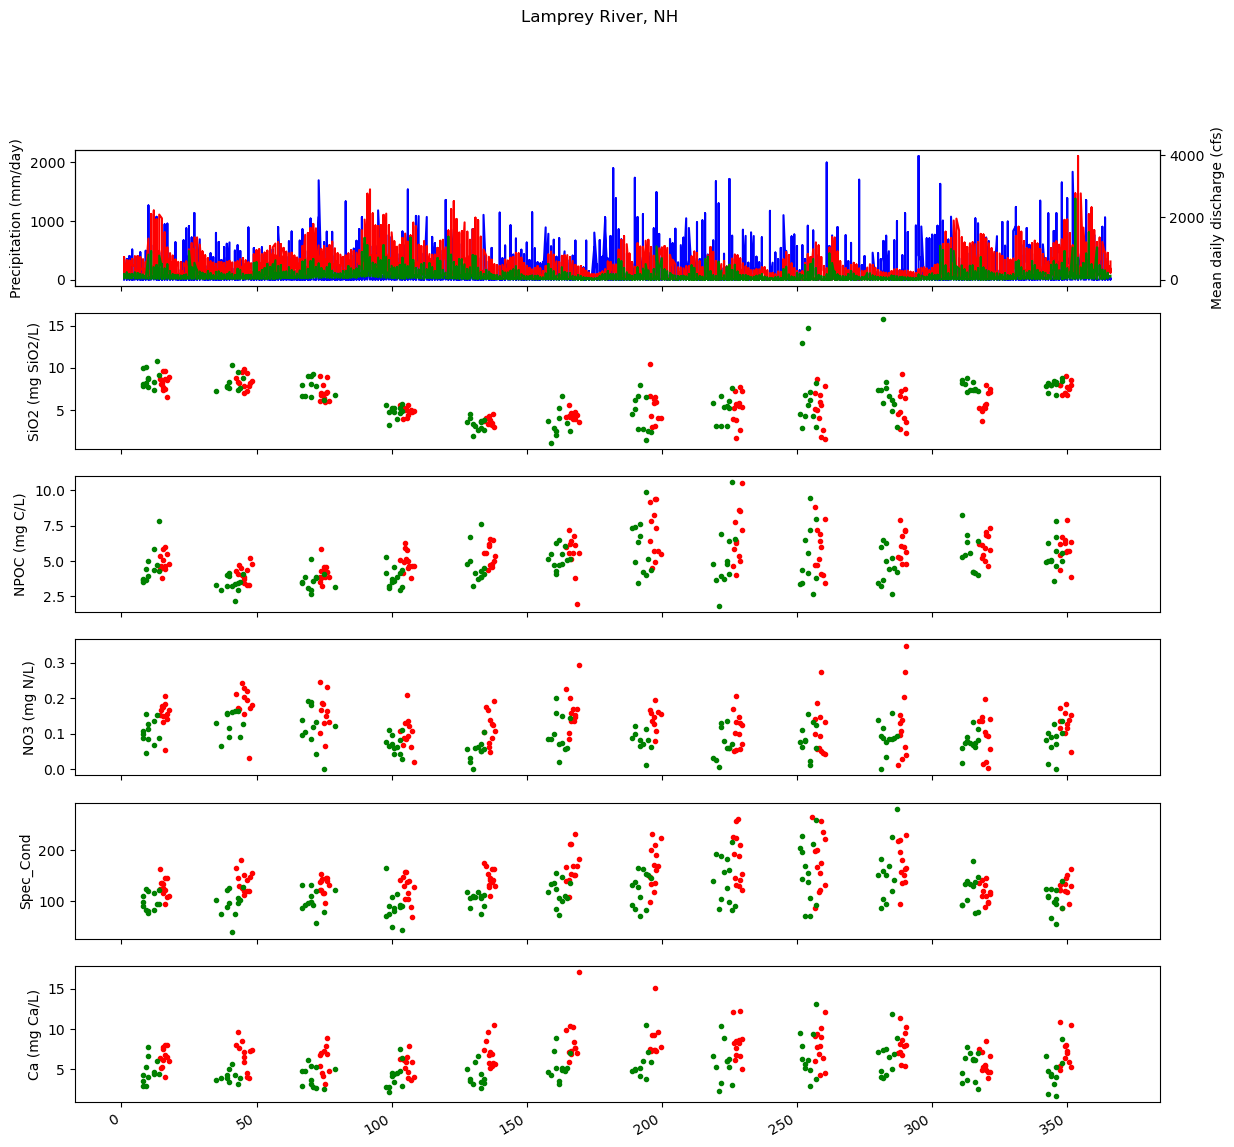

In [14]:
# Plot preliminary timeseries with solute data by day of year

# Sort data
df_runoff27.sort_values(by='DOY', inplace=True)
df_runoff72.sort_values(by='DOY', inplace=True)
data_p.sort_values(by='DOY', inplace=True)

fig_title = "Lamprey River, NH"

# One subplot for precip/discharge + one per analyte
fig, axes = plt.subplots(len(analytes) + 1, figsize=(14, 14), sharex=True)


ax1 = axes[0]
ax3 = ax1.twinx()

ax1.plot(data_p['DOY'], data_p['PRCP_MM'], 'b-', label='Precipitation')
ax3.plot(df_runoff72['DOY'], df_runoff72['Q_CFS'], 'r-', label='LMP 72')
ax3.plot(df_runoff27['DOY'], df_runoff27['Q_CFS'], 'g-', label='LMP 27')

ax1.set_ylabel('Precipitation (mm/day)')
ax3.set_ylabel('Mean daily discharge (cfs)')

# Loop through analytes and plot each one
for ax, col in zip(axes[1:], analytes):
    ax.plot(merged_72['DOY'], merged_72[col], 'r.')
    ax.plot(merged_27['DOY'], merged_27[col], 'g.')
    ax.set_ylabel(col)


fig.suptitle(fig_title)
fig.autofmt_xdate()
plt.show()


Figure 2: Discharge, precipitation, and water chemistry by day of year.
Precipitation is plotted in mm/day and mean daily discharge is plotted in cubic feet per second. Discharge and water chemistry are plotted in green for LMP 27 and red for LMP 72. Seasonal trends are apparent in silicon dioxide and DOC where each solute decreases and increases respectively during the growing season. Trends in nitrate appear more sporadic and calcium appears relatively unchanged throughout the year.

In [15]:
# Interpolate missing data
# necessary for Power law function

for col in analytes:
    merged_72[col] = merged_72[col].interpolate(method='time')
    merged_27[col] = merged_27[col].interpolate(method='time')

In [16]:
# Calculate flux of each solute

for col in analytes:
    merged_72[f'{col} flux'] = flux(merged_72, col)
    merged_27[f'{col} flux'] = flux(merged_27, col)


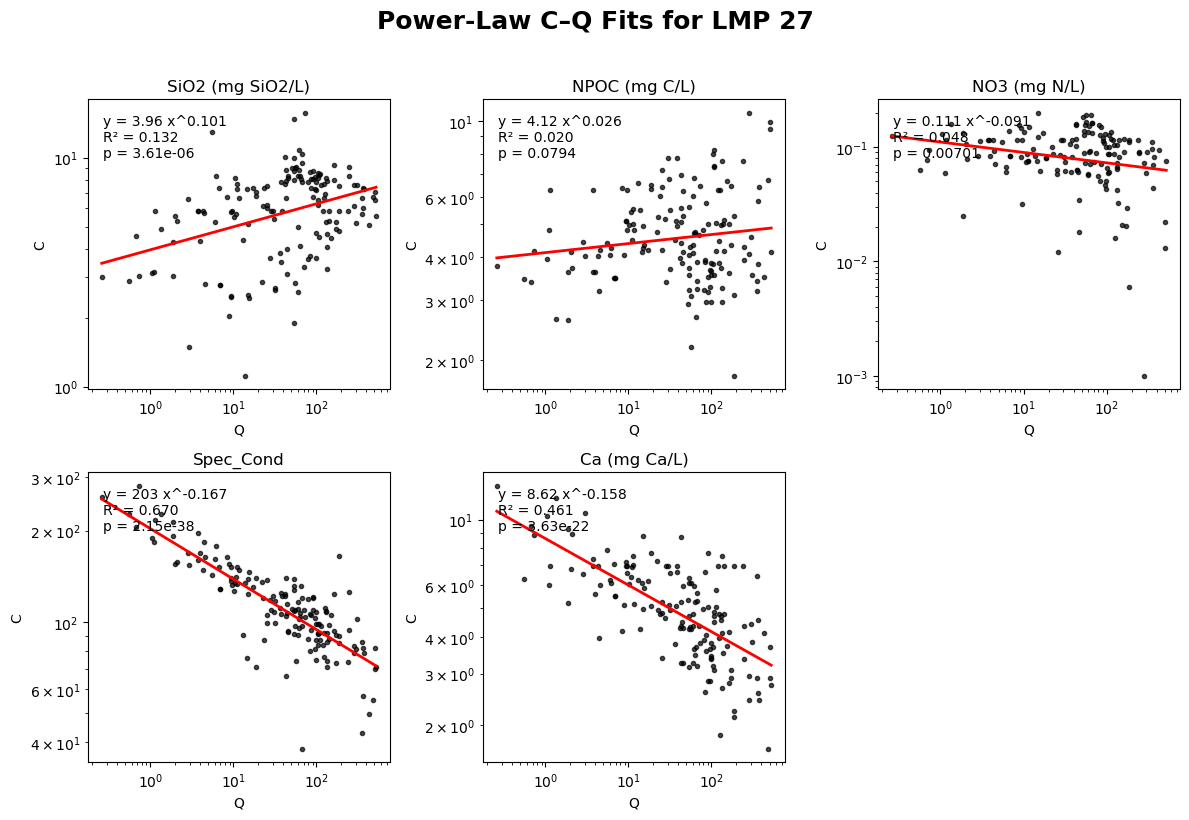

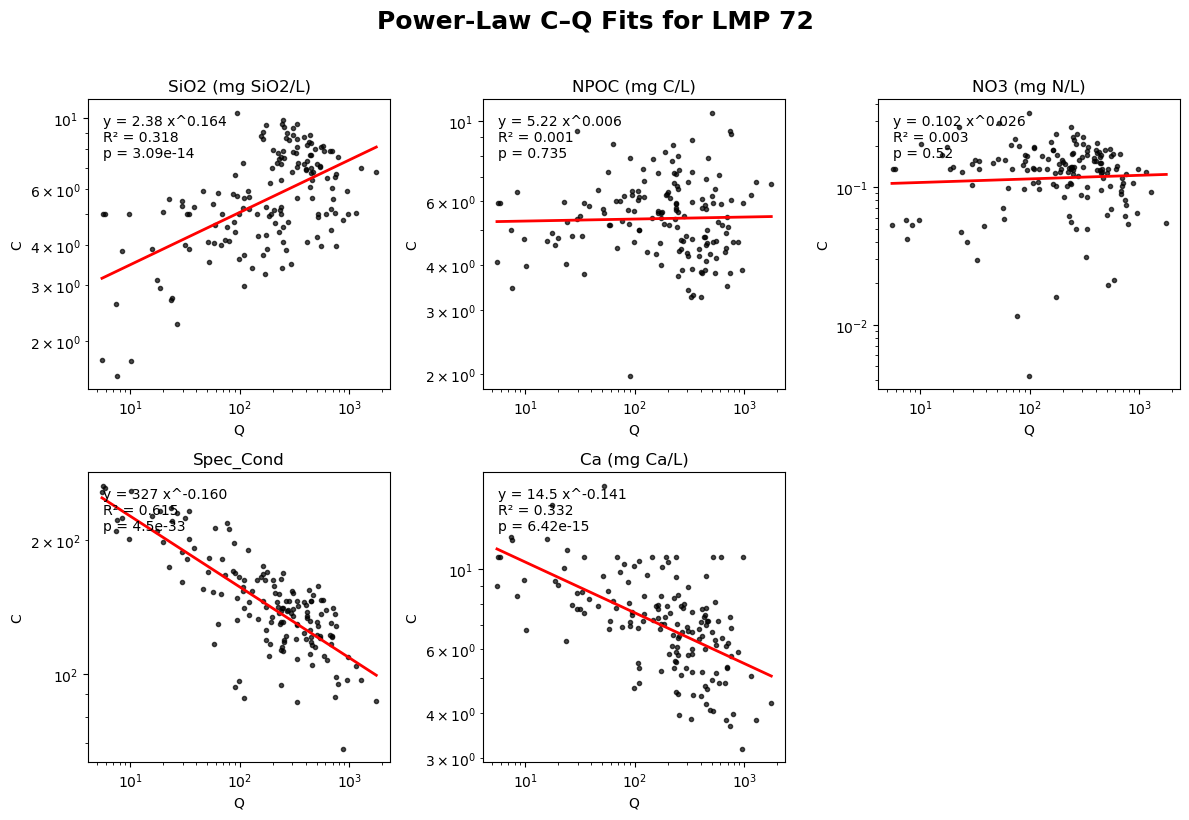

In [17]:
# Plot power law CQ
# LMP 27
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

datasets = [(merged_27['Q_CFS'], merged_27[a], a) for a in analytes]

for ax, (x, y, label) in zip(axes.flatten(), datasets):
    powerlaw_plot(x, y, xlabel="Q", ylabel="C", fig_title=label, ax=ax)

# Hide the unused 6th panel
axes.flatten()[5].set_visible(False)

fig.suptitle("Power-Law C–Q Fits for LMP 27", fontsize=18, fontweight='bold', y=1.02)
fig.tight_layout()
plt.show()

# LMP 72
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

datasets = [(merged_72['Q_CFS'], merged_72[a], a) for a in analytes]

for ax, (x, y, label) in zip(axes.flatten(), datasets):
    powerlaw_plot(x, y, xlabel="Q", ylabel="C", fig_title=label, ax=ax)

# Hide the unused 6th panel
axes.flatten()[5].set_visible(False)

fig.suptitle("Power-Law C–Q Fits for LMP 72", fontsize=18, fontweight='bold', y=1.02)
fig.tight_layout()
plt.show()


Figure 3: CQ plots for each solute.
Each CQ plot is based on a power-law relationship. Solutes from LMP 27 are in the top panel and solutes from LMP 72 are below. In both sites, silicon dioxide has a positive slope, specific conductance and calcium have negative slopes, and DOC and nitrate appear relatively chemostatic.

In [18]:
# Calculate P/R for each day

df_runoff27['P/R'] = df_runoff27['PRCP_MM']/df_runoff27['runoff_MM']
df_runoff72['P/R'] = df_runoff72['PRCP_MM']/df_runoff72['runoff_MM']


/var/folders/86/3vj2gl_x4cg1shtp3zdz7nvm0000gn/T/ipykernel_80779/559743495.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  b1 = ax.boxplot(data72, positions=positions72, widths=width, patch_artist=True,


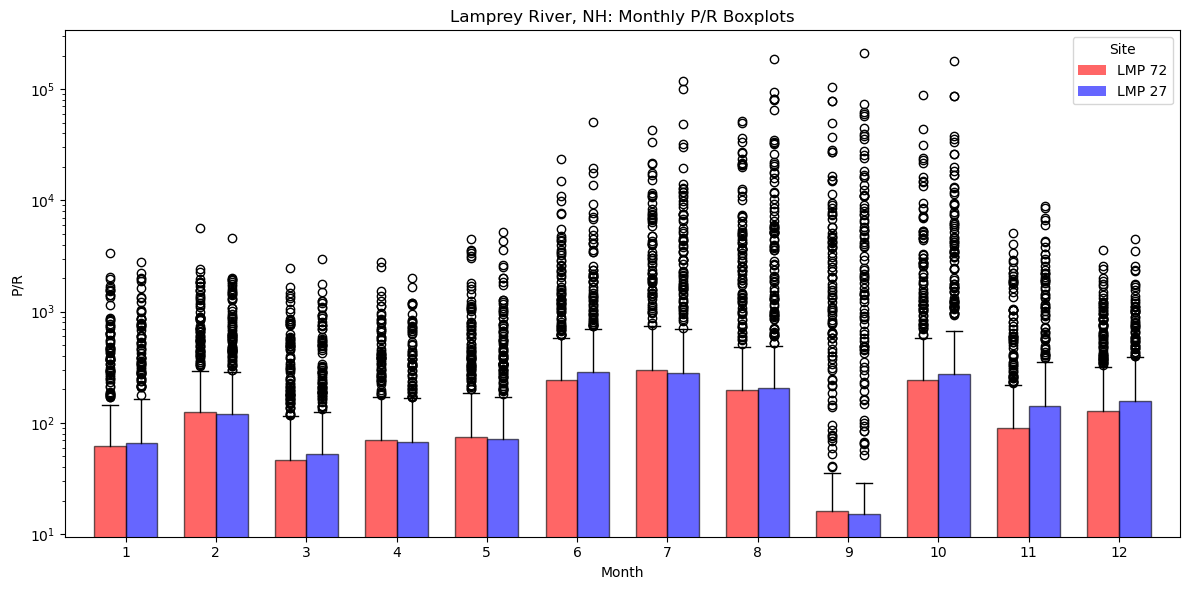

In [19]:
# Plot P/R by month for each site

# Prep data
df72 = df_runoff72.copy()
df72.index = pd.to_datetime(df72.index)
df72['Month'] = df72.index.month

df27 = df_runoff27.copy()
df27.index = pd.to_datetime(df27.index)
df27['Month'] = df27.index.month

months = np.arange(1, 13)

# Collect data per month for each site
data72 = [df72.loc[df72['Month'] == m, 'P/R'].dropna() for m in months]
data27 = [df27.loc[df27['Month'] == m, 'P/R'].dropna() for m in months]

# Plot settings
width = 0.35  # width of each box
fig, ax = plt.subplots(figsize=(12, 6))

# Positions for each site (side-by-side)
positions72 = months - width/2
positions27 = months + width/2

# Boxplots
b1 = ax.boxplot(data72, positions=positions72, widths=width, patch_artist=True,
                boxprops=dict(facecolor='red', alpha=0.6),
                medianprops=dict(color='black', linewidth=2),
                labels=months)

b2 = ax.boxplot(data27, positions=positions27, widths=width, patch_artist=True,
                boxprops=dict(facecolor='blue', alpha=0.6),
                medianprops=dict(color='black', linewidth=2))

# Labels and title
ax.set_xlabel("Month")
ax.set_ylabel("P/R")
ax.set_title("Lamprey River, NH: Monthly P/R Boxplots")
ax.set_yscale('log')
ax.set_xticks(months)
ax.set_xticklabels([str(m) for m in months])

# Legend using proxy artists
legend_elements = [Patch(facecolor='red', alpha=0.6, label='LMP 72'),
                   Patch(facecolor='blue', alpha=0.6, label='LMP 27')]
ax.legend(handles=legend_elements, title='Site')

plt.tight_layout()
plt.show()

Figure 4: Precipitation-runoff (P/R) ratio by month.
P/R was calculated for each day at each site and then grouped and plotted by month of the year to observe any seasonal trends. LMP 27 is plotted in blue and LMP 72 is plotted in red.
There appears to be a slight increasing trend in P/R towards the end of the growing season, peaking in August.

In [20]:
# Calculate antecedent P/R

df_runoff72 = calc_antpr(df_runoff72)
df_runoff27 = calc_antpr(df_runoff27)


# Results: data analysis

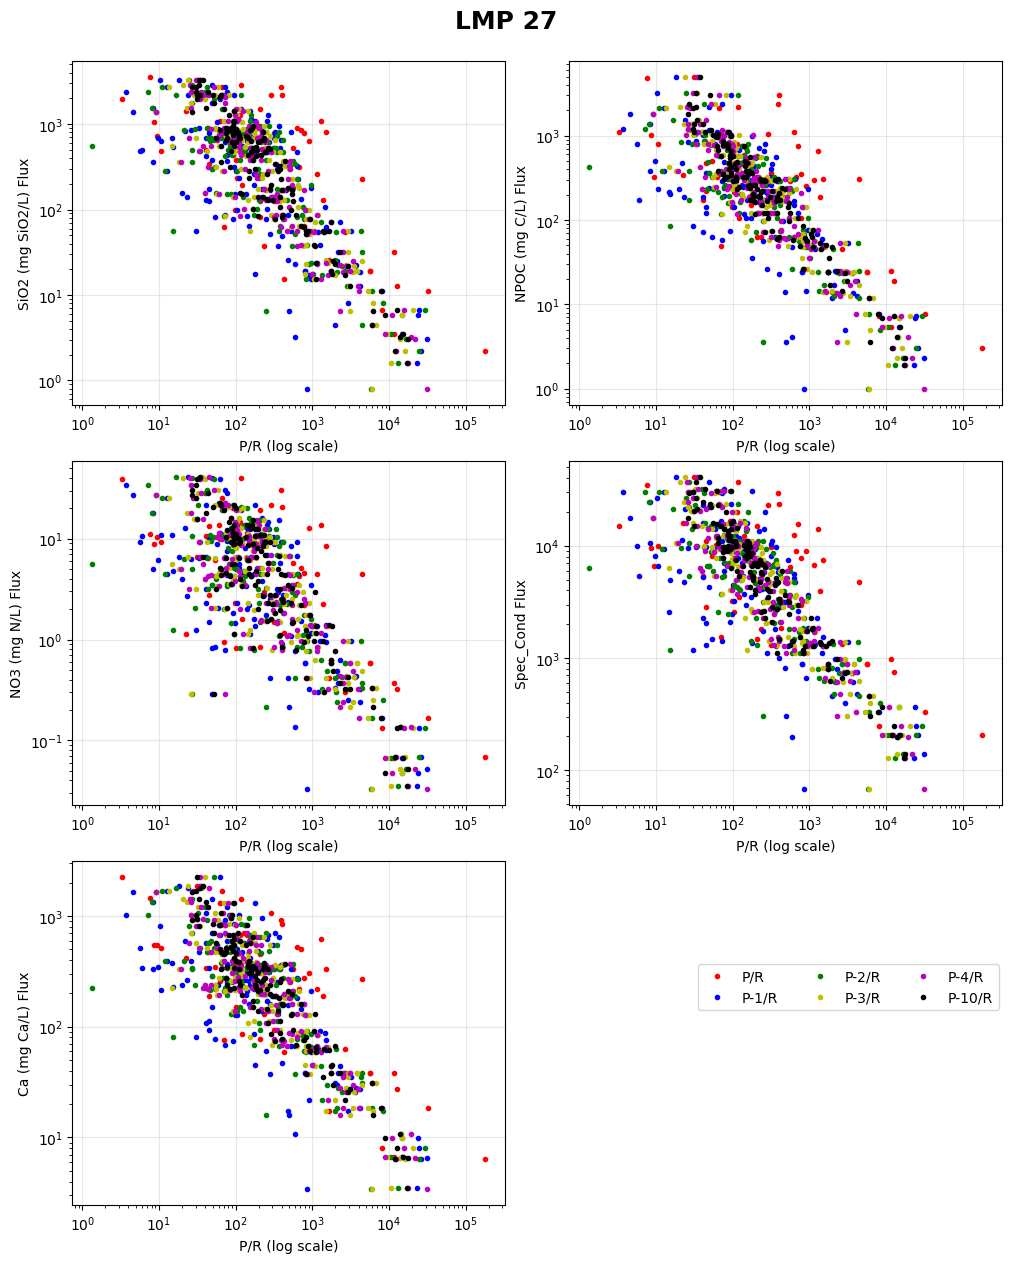

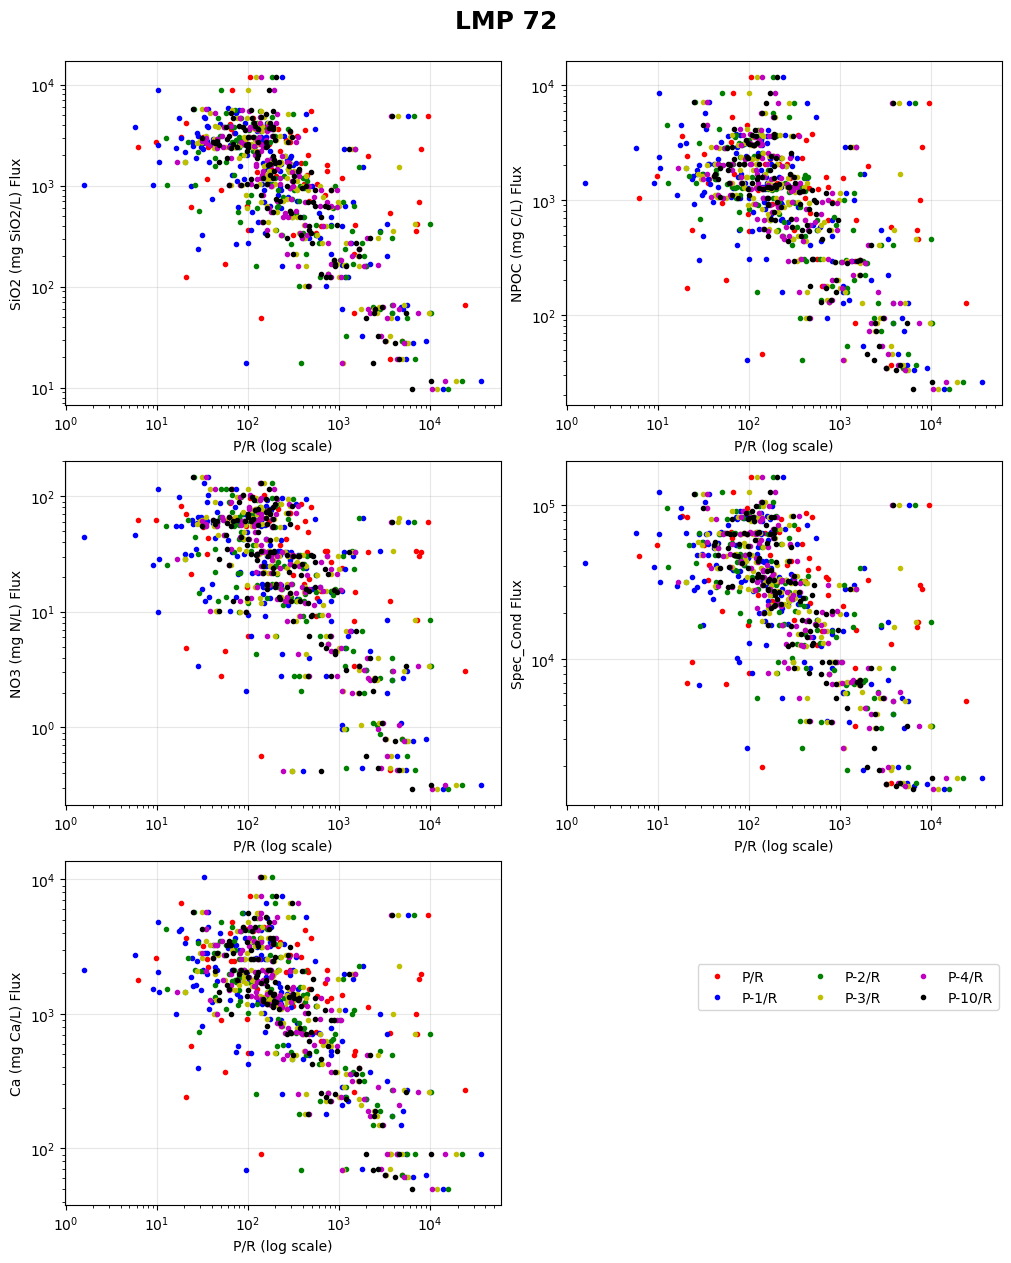

In [21]:
# Plot analyte flux with P/R

# LMP 27
plot_flux_pr(
    site_df=merged_27,
    runoff_df=df_runoff27,
    analytes=analytes,
    site_name="LMP 27"
)

# LMP 72
plot_flux_pr(
    site_df=merged_72,
    runoff_df=df_runoff72,
    analytes=analytes,
    site_name="LMP 72"
)


Figure 5: solute flux and antecedent P/R.
At each site, the flux for each solute is plotted against increasingly antecedent P/R, from instantaneous P/R to precipitation summed from the previous 10 weeks /runoff. Fluxes from LMP 27 are plotted in the top panel and fluxes from LMP 72 are plotted in the bottome panel.
Including more antecedent P/R allows us to see how storage changes over temporal scales and how much antecedent precipitation impacts the expansion/contraction of the LRHO.
More antecedent P/R does not seem to more strongly correlate with solute fluxes, regardless of solute or catchment size.

<Figure size 640x480 with 0 Axes>

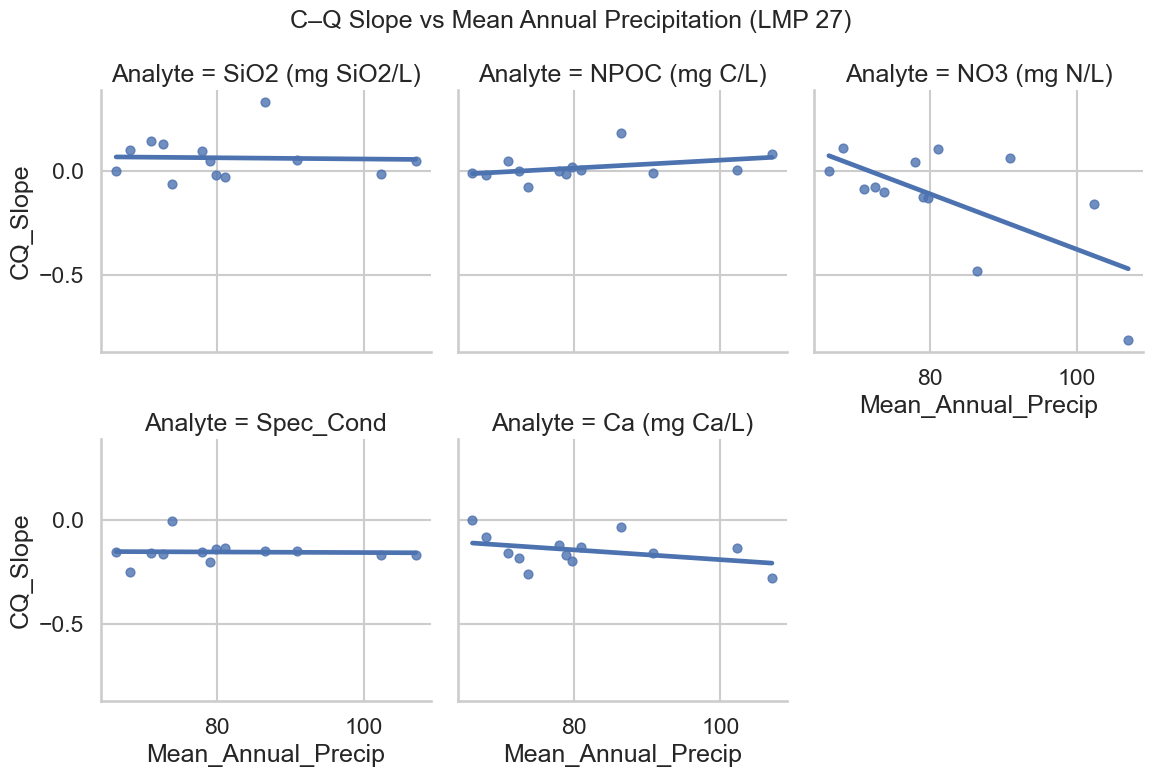

<Figure size 640x480 with 0 Axes>

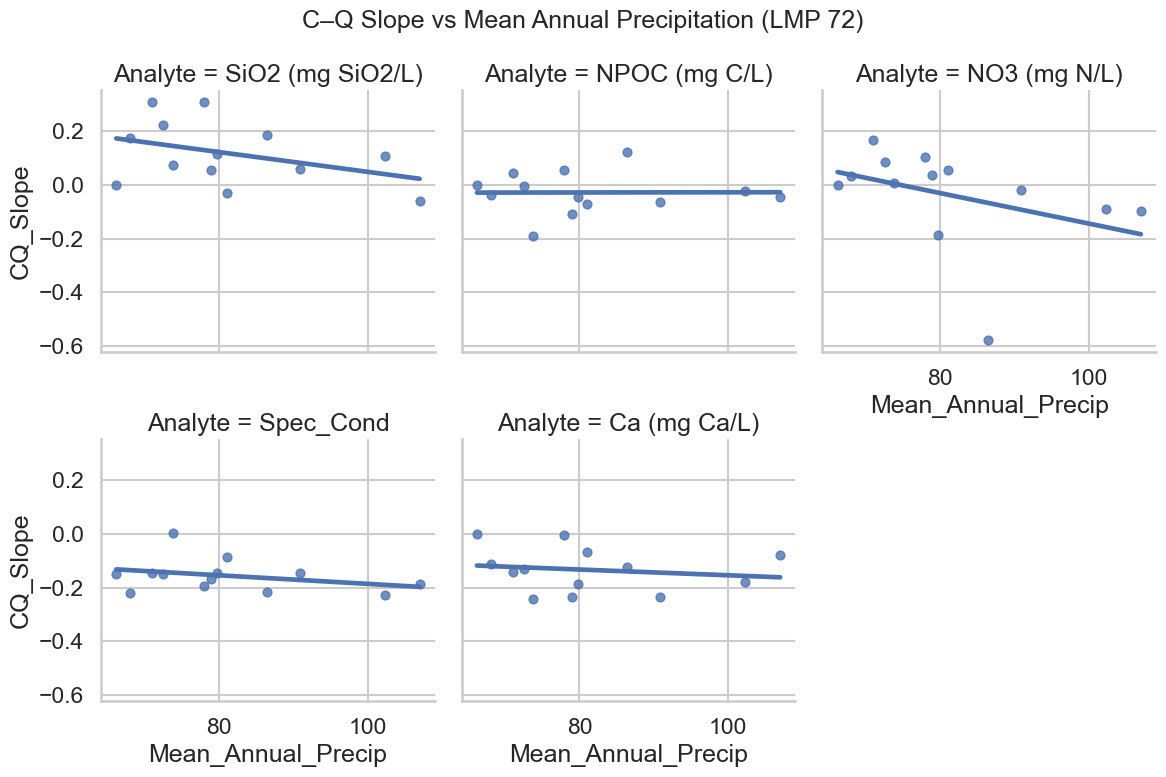

In [22]:
# Plot CQ slope and Mean Annual Precip.
#27
slopes27 = plot_CQb_MAP(
    merged_df=merged_27,
    runoff_df=df_runoff27,
    analytes=analytes,
    site_name="LMP 27"
)

#72
slopes72 = plot_CQb_MAP(
    merged_df=merged_72,
    runoff_df=df_runoff72,
    analytes=analytes,
    site_name="LMP 72"
)


Figure 6: CQ slope and mean annual precipitation for each solute at LMP 27 and LMP 72.
Mean annual precipitation does not appear to have a significant effect on silicon dioxide, DOC, specific conductance, or calcium, regardless of catchment size. Nitrate appears to demonstrate more diluting behavior with higher annual precipitation.

<Figure size 640x480 with 0 Axes>

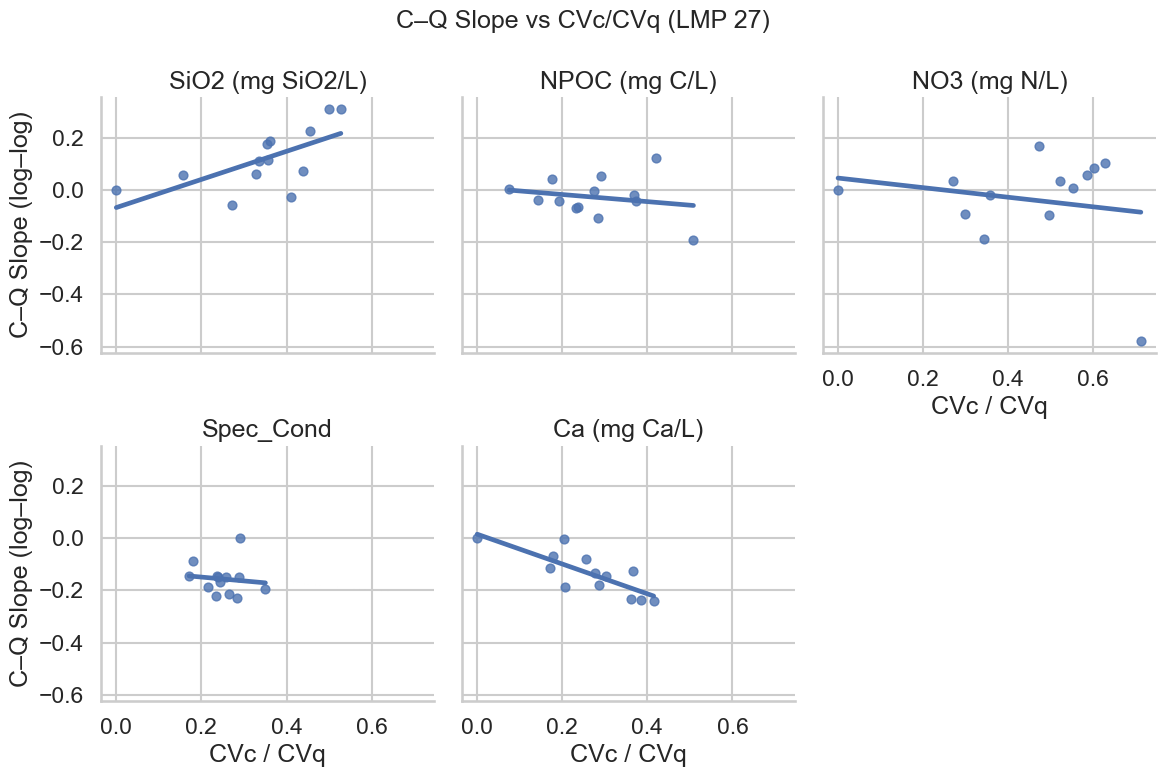

<Figure size 640x480 with 0 Axes>

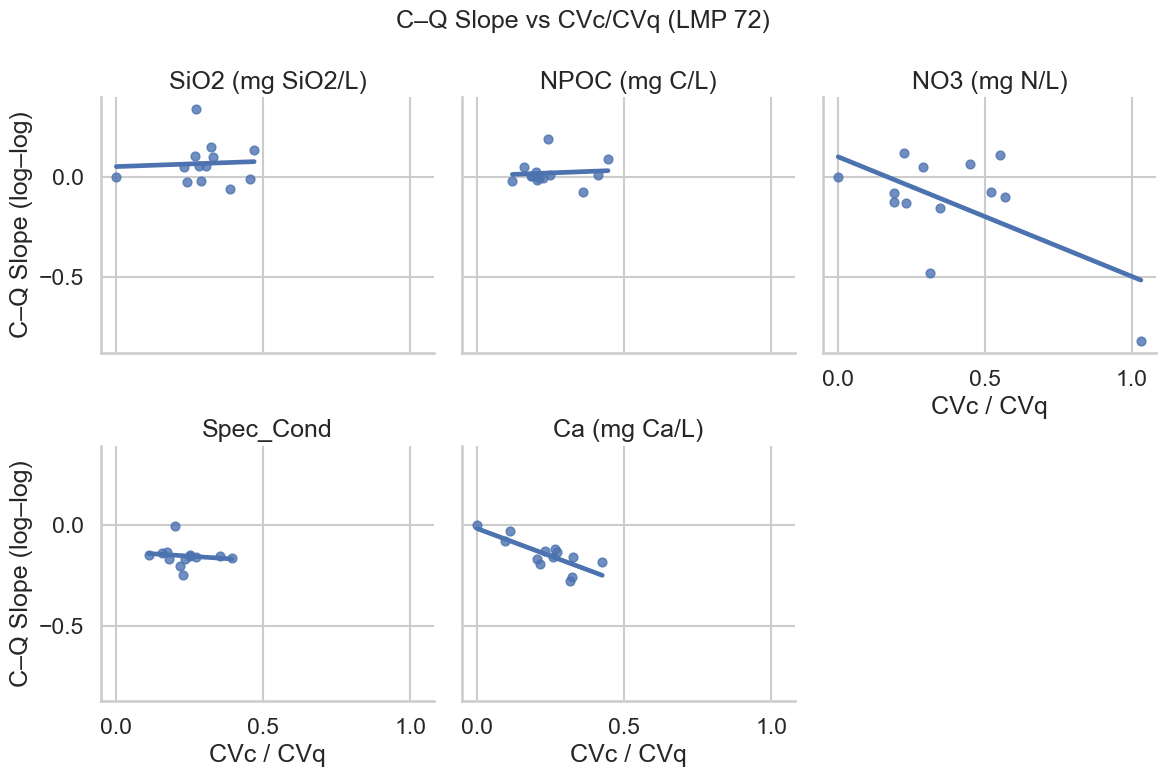

In [23]:
# Plot CQ slope and CVc/CVq
# 27
cv_slope_72 = plot_CQb_CVcCVq(
    df=merged_72,
    analytes=analytes,
    site_name="LMP 27"
)

#72
cv_slope_27 = plot_CQb_CVcCVq(
    df=merged_27,
    analytes=analytes,
    site_name="LMP 72"
)



Figure 7: CQ slope and CQ variance (CVc/CVq) for each solute in LMP 27 and LMP 72.
Plotting CQ slope with CVc/CVq helps better differentiate chemostatic from chemodynamic behavior. Chemostasis is observed in solutes with low CQ variance and slopes close to 0, like DOC and specific conductance regardless of catchment size, and silicon dioxide in LMP 72. High variance and slopes close to 0 may reflect the biogeochemical transformation of solutes during transport. Finally, high variance and non-zero slopes may indicate variable connectivity between solute sources and the stream, as seen in silicon dioxide in LMP 27, and calcium and nitrate regardless of catchment size.

# Discussion and conclusions
There are apparent seasonal trends in line with the growing season for silica, DOC, nitrate and specific conductance, whereas calcium, a deeper sourced solute, is more conservative.

For the CQ analysis, DOC and nitrate demonstrate diluting behavior in LMP 27, where they become more source limited with more discharge. However, when scaling up in catchment size, DOC and nitrate behave more chemostatically. This is consistent in literature where the variability of different behaviors seem to collapse or cancel each other out when scaling up in watershed size. In contrast however, nitrate demonstrates strong diluting behavior in LMP 72 when plotted against CQ variance, whereas nitrate in LMP 27 appears chemostatic.

There are apparent seasonal trends with P/R, suggesting that storage capacity changes over the course of a year. This information can be used for future studies and models of water and solute movement through the Lamprey. Although P/R appears to change over the course of the year, it does not appear to change significantly when incorporating more antecedent precipitation. Antecedent P/R also does not seem to significantly impact solute fluxes, regardless of catchment size. 

In LMP 27 and 72, nitrate becomes more source limited in more wet years. This is in contrast of my hypothesis that more wet years will result in more enriching behavior from shallow-sourced solutes from the critical zone. However, DOC does not appear to be influenced by mean annual precipitation. On the other hand, silicon dioxide and calcium appear relatively chemostatic regardless of mean annual precipitation, supporting my hypothesis that deep-sourced solutes from the critical zone will be relatively unaffected by annual precipitation because they are continuously imprinting on surface water chemistry through deeper flow paths that are more consistently present. 

Although higher annual precipitation may result in higher flow paths, nitrate may be displaying diluting behavior because the high flow paths eventually flush out any available solute from the source. This highlights a key limitation in this study, where chemistry data for our sites are only available on weekly to monthly scales, constraining the detail with which we can analyze changes to surface water chemistry. Future work will analyze how seasonal trends influence the observed CQ patterns and will employ high-frequency sensors to capture finer detail in surface water chemistry.

# Literature 
Speir, S. L., Rose, L. A., Blaszczak, J. R., Kincaid, D. W., Fazekas, H. M., Webster, A. J., Wolford, M. A., Shogren, A. J., & Wymore, A. S. (2024). Catchment concentration–discharge relationships across temporal scales: A review. WIREs Water, 11(2), e1702. https://doi.org/10.1002/wat2.1702

Stewart, B., Shanley, J. B., Kirchner, J. W., Norris, D., Adler, T., Bristol, C., Harpold, A. A., Perdrial, J. N., Rizzo, D. M., Sterle, G., Underwood, K. L., Wen, H., & Li, L. (2022). Streams as Mirrors: Reading Subsurface Water Chemistry From Stream Chemistry. Water Resources Research, 58(1), e2021WR029931. https://doi.org/10.1029/2021WR029931

Wymore, A. S., Shattuck, M. D., Potter, J. D., Snyder, L., & McDowell, W. H. (2021). The Lamprey River Hydrological Observatory: Suburbanization and changing seasonality. Hydrological Processes, 35(4), e14131. https://doi.org/10.1002/hyp.14131
